- assume fs recon done
- resamp surface & annotations
- mkheadsurf && coreg
- http://martinos.org/mne/stable/auto_tutorials/plot_forward.html#sphx-glr-auto-tutorials-plot-forward-py
- mne simulation
- tvb simulation
- id contacts

In [3]:
import mne
import nibabel

Make high resolution head surface for coregistration

In [21]:
!mkheadsurf -s ol

INFO: log file is /opt/freesurfer/subjects/ol/scripts/mkheadsurf.log
--------------------------------
Mon May 15 07:47:26 UTC 2017
/opt/work
mri_seghead --invol /opt/freesurfer/subjects/ol/mri/T1.mgz --outvol /opt/freesurfer/subjects/ol/mri/seghead.mgz --fill 1 --thresh1 20 --thresh2 20 --nhitsmin 2
--------------------------------
input volume:  /opt/freesurfer/subjects/ol/mri/T1.mgz
output volume: /opt/freesurfer/subjects/ol/mri/seghead.mgz
threshold1:    20
threshold2:    20
nhitsmin:      2
fill value:    1
Loading input volume
Filling Columns
Filling Rows
Filling Slices
Merging and Inverting
Growing
Counting
N Head Voxels = 4345974
N Back Voxels = 12431242
Avg. Back Intensity = 1.626087
Max. Back Intensity = 232.000000
Writing output
Done
--------------------------------
Mon May 15 07:47:35 UTC 2017
/opt/work
mri_tessellate /opt/freesurfer/subjects/ol/mri/seghead.mgz 1 /opt/freesurfer/subjects/ol/surf/lh.seghead
--------------------------------
$Id: mri_tessellate.c,v 1.38.2.1 201

Make boundary element surfaces from T1,

Convert a 4D MEG run to FIF format

In [23]:
import mne
mne.io.read_raw_bti('02-02-15_13h38/4/c,rfDC', preload=True).save('4-raw.fif')

Reading 4D PDF file /opt/work/02-02-15_13h38/4/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /opt/work/02-02-15_13h38/4/hs_file
... putting digitization points in Neuromag coordinates
... Computing new device to head transform.
Done.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0
Reading 0 ... 1220705  =      0.000 ...   599.999 secs...
Writing /opt/work/4-raw.fif
Closing /opt/work/4-raw.fif [done]


Manually coregister MRI & MEG coordinate systems

In [17]:
!mne coreg

^C
Traceback (most recent call last):
  File "/opt/conda/bin/mne", line 39, in <module>
    sys.exit(subprocess.call([sys.executable, cmd_path] + sys.argv[2:]))
  File "/opt/conda/lib/python2.7/subprocess.py", line 168, in call
    return Popen(*popenargs, **kwargs).wait()
  File "/opt/conda/lib/python2.7/subprocess.py", line 1073, in wait
    pid, sts = _eintr_retry_call(os.waitpid, self.pid, 0)
  File "/opt/conda/lib/python2.7/subprocess.py", line 121, in _eintr_retry_call
    return func(*args)
KeyboardInterrupt


![mne-coreg](img/mne-coreg.png)

Resample subject's cortical surfaces and annotations via `fsaverage5` subject, from 122k vertices to 10k, using new feature of FreeSurfer v6:

In [24]:
!mris_info $SUBJECTS_DIR/ol/surf/lh.pial 2>&1 | grep "num vertices"

num vertices: 110721


In [25]:
%%bash

for hemi in lh rh
do
    mri_surf2surf \
        --srcsubject ol \
        --trgsubject fsaverage5 \
        --hemi $hemi \
        --sval-xyz pial \
        --tval pial.ol \
        --tval-xyz $SUBJECTS_DIR/ol/mri/T1.mgz
        
    cp $SUBJECTS_DIR/fsaverage5/surf/$hemi.pial.ol \
       $SUBJECTS_DIR/ol/surf/$hemi.pial.fsaverage5
        
    mri_surf2surf \
        --srcsubject ol \
        --trgsubject fsaverage5 \
        --hemi $hemi \
        --sval-annot $SUBJECTS_DIR/ol/label/$hemi.aparc.annot \
        --tval $SUBJECTS_DIR/ol/label/$hemi.aparc.annot.fsaverage5
done


$Id: mri_surf2surf.c,v 1.103 2015/11/05 22:07:33 greve Exp $

setenv SUBJECTS_DIR /opt/freesurfer/subjects
cd /opt/work
mri_surf2surf --srcsubject ol --trgsubject fsaverage5 --hemi lh --sval-xyz pial --tval pial.ol --tval-xyz /opt/freesurfer/subjects/ol/mri/T1.mgz 

sysname  Linux
hostname 7c9d7df37536
machine  x86_64
user     root
srcsubject = ol
srcval     = (null)
srctype    = 
trgsubject = fsaverage5
trgval     = pial.ol
trgtype    = 
srcsurfreg = sphere.reg
trgsurfreg = sphere.reg
srchemi    = lh
trghemi    = lh
frame      = 0
fwhm-in    = 0
fwhm-out   = 0
label-src  = (null)
label-trg  = (null)
OKToRevFaceOrder  = 1
UseDualHemi = 0
Reading source surface reg /opt/freesurfer/subjects/ol/surf/lh.sphere.reg
Loading source data
Reading surface file /opt/freesurfer/subjects/ol/surf/lh.pial
Reading target surface reg /opt/freesurfer/subjects/fsaverage5/surf/lh.sphere.reg
Done
Using surf2surf_nnfr()
Mapping Source Volume onto Source Subject Surface
surf2surf_nnfr: building source hash 

reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/tanha_002/users/greve/fsdev.build/average/colortable_desikan_killiany.txt)
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/tanha_002/users/greve/fsdev.build/average/colortable_desikan_killiany.txt)


In [26]:
!mris_info $SUBJECTS_DIR/ol/surf/lh.pial.fsaverage5 2>&1 | grep "num vertices"

num vertices: 10242


In [28]:
!mne watershed_bem -s ol


Running mri_watershed for BEM segmentation with the following parameters:

SUBJECTS_DIR = /opt/freesurfer/subjects
SUBJECT = ol
Results dir = /opt/freesurfer/subjects/ol/bem/watershed

Running subprocess: mri_watershed -useSRAS -surf /opt/freesurfer/subjects/ol/bem/watershed/ol /opt/freesurfer/subjects/ol/mri/T1.mgz /opt/freesurfer/subjects/ol/bem/watershed/ws

Mode:          use surfaceRAS to save surface vertex positions
Mode:          Saving out BEM surfaces

*********************************************************
The input file is /opt/freesurfer/subjects/ol/mri/T1.mgz
The output file is /opt/freesurfer/subjects/ol/bem/watershed/ws

*************************WATERSHED**************************
Sorting...
      T1-weighted MRI image
      modification of the preflooding height to 15 percent
      Count how many 110 voxels are present :  107825

      Find the largest 110-component...
             heap usage = 212684 Kbytes.
             current max segment has 82179 voxels
       

In [29]:
!ls ../freesurfer/subjects/ol/bem

brain.surf	  ol-head.fif	   outer_skull.surf
inner_skull.surf  outer_skin.surf  watershed


We can check those new surfaces visually along with the BEM surfaces:

Using surface: /opt/freesurfer/subjects/ol/bem/inner_skull.surf
Using surface: /opt/freesurfer/subjects/ol/bem/outer_skull.surf
Using surface: /opt/freesurfer/subjects/ol/bem/outer_skin.surf


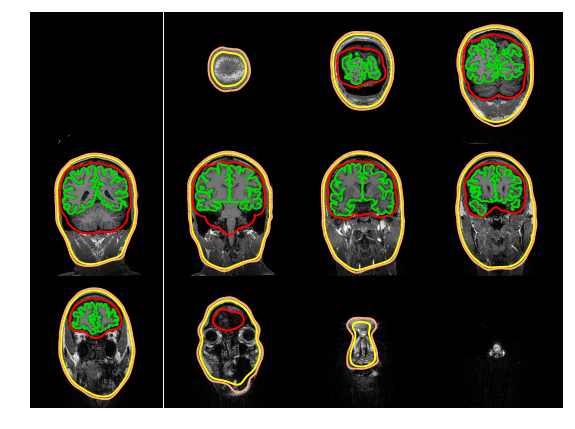

In [30]:
_ = mne.viz.plot_bem(
    subject='ol',
    brain_surfaces='pial.fsaverage5',
    orientation='coronal'
)

In [46]:
try:
    src = mne.read_source_spaces('/opt/freesurfer/subjects/ol/bem/ol-all-src.fif')
except:
    src = mne.setup_source_space(subject='ol', spacing='all', surface='pial.fsaverage5')    

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read


In [ ]:
bem_model = mne.make_bem_model('ol')
bem = mne.make_bem_solution(bem_model)

for i in [1, 2, 3, 4]:
    fwd = mne.make_forward_solution('%d-raw.fif' % i, 'ol-trans.fif', src, bem, eeg=False)
    fwd_fixed = mne.convert_forward_solution(fwd, force_fixed=True)
    mne.write_forward_solution('%d-fwd.fif' % i, fwd_fixed)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is   1.97 -19.70  21.96 mm
outer skull CM is   1.94 -19.47  21.53 mm
inner skull CM is   2.83 -23.78  30.59 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    0.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately 1000.0 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation sol

In [45]:
mne.read_source_spaces?

In [36]:
fwd_fixed['sol']['data'].shape

(248, 20484)

In [38]:
reg_map, _, labels = nibabel.freesurfer.read_annot(
    '/opt/freesurfer/subjects/ol/label/lh.aparc.a2009s.annot.fsaverage5')

In [39]:
reg_map.shape

(10242,)

In [42]:
fwd_fixed['src']

<SourceSpaces: [<surface (lh), n_vertices=10242, n_used=10242, coordinate_frame=head>, <surface (rh), n_vertices=10242, n_used=10242, coordinate_frame=head>]>